# Carregando Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Mounted at /content/drive


# Checando GPU

In [2]:
!nvidia-smi

Thu Sep 22 12:54:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Carregando Pacotes

In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from pathlib import Path
import shutil

In [4]:
print(tf.__version__)

2.8.2


# Paramêtros

In [5]:
# Classes
num_classes = 14

# Epochs
n_epochs = 100

# Tamanho imagem
img_rows, img_cols = 224, 224

input_shape = (img_rows, img_cols, 3)

#Batch size

batch_size = 32

# seed
seed=42

#Path base de dados Drive
nome_base = 'oregon_wildlife'
nome_zip = nome_base + '.zip'
dir_path = Path('/content/drive/MyDrive/CI1394/')
zip_path = dir_path/nome_zip

In [6]:
#loss
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#métricas
metrics = ['accuracy'] 

In [7]:
#modelo
nome_modelo = 'resnet50' 
dir_path_modelo = Path('/content/drive/MyDrive/CI1394/modelos/')
zip_name = nome_modelo + '.zip'
drive_path_modelo = dir_path_modelo/zip_name

#Carregar Base de Dados

In [8]:
!cp {zip_path} .
!unzip -q {nome_zip} 
!rm {nome_zip}

In [9]:
path_train = '/content/' + nome_base + '/train'
path_test = '/content/' + nome_base + '/test'

In [10]:
train_dataset = image_dataset_from_directory(
        path_train,
        image_size=(img_rows, img_cols),
        color_mode="rgb",
        batch_size=batch_size,
        shuffle=True)
test_dataset = image_dataset_from_directory(
        path_test,
        image_size=(img_rows, img_cols),
        color_mode="rgb",
        batch_size=batch_size,
        shuffle=False)

Found 3136 files belonging to 14 classes.
Found 784 files belonging to 14 classes.


https://www.tensorflow.org/guide/data_performance

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE) #Otimização
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

#Data Augmentation

https://www.tensorflow.org/versions/r2.4/api_docs/python/tf/keras/layers/experimental/preprocessing (TF 2.4)

In [12]:
data_augmentation = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
                                         tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
                                         tf.keras.layers.experimental.preprocessing.RandomContrast(0.2, 0.2)])

# Modelo

https://www.tensorflow.org/tutorials/images/transfer_learning

https://keras.io/guides/transfer_learning/

In [13]:
resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
resnet50.trainable = False #Para o primeiro treinamento as camadas convolucionais não serão treinadas
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = resnet50(x, training=False) #Camadas de Batch Normalization em inference mode
x = GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.4)(x) # Camada de Dropout
predictions = Dense(num_classes)(x) #Camada Densa sem ativação, pois a loss foi definida como from_logits=True
model = Model(inputs, predictions)
model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0      

# Treinamento da Camada Densa

In [14]:
opt_dense = keras.optimizers.Adam()
model.compile(metrics=metrics, loss=loss, optimizer=opt_dense)
callbacks_dense = [EarlyStopping(patience=10)]

In [ ]:
history_dense =model.fit(train_dataset, epochs=n_epochs, verbose=1, validation_data=test_dataset, callbacks=callbacks_dense)

Epoch 1/100
98/98 [==============================] - 42s 264ms/step - loss: 1.6572 - accuracy: 0.4872 - val_loss: 0.5885 - val_accuracy: 0.8099
Epoch 2/100
98/98 [==============================] - 13s 133ms/step - loss: 0.8299 - accuracy: 0.7274 - val_loss: 0.5053 - val_accuracy: 0.8227
Epoch 3/100
98/98 [==============================] - 13s 134ms/step - loss: 0.7006 - accuracy: 0.7663 - val_loss: 0.4791 - val_accuracy: 0.8355
Epoch 4/100
98/98 [==============================] - 13s 136ms/step - loss: 0.5999 - accuracy: 0.7943 - val_loss: 0.4340 - val_accuracy: 0.8495
Epoch 5/100
53/98 [===============>..............] - ETA: 5s - loss: 0.5647 - accuracy: 0.8078

# Treinamento Completo

In [ ]:
resnet50.trainable = True #Liberando todas as camadas com excessão das camadas de Batch Normalization

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0   

In [ ]:
opt_completo = keras.optimizers.Adam(learning_rate=5e-6)
model.compile(metrics=metrics, loss=loss, optimizer=opt_completo)
callbacks_dense_completo = [EarlyStopping(patience=15), 
                            ModelCheckpoint(filepath=nome_modelo, save_weights_only=False, 
                                            verbose=1, monitor='val_accuracy', mode='max', 
                                            save_best_only=True)]

In [ ]:
history_completo = model.fit(train_dataset, epochs=n_epochs, verbose=1, validation_data=test_dataset, callbacks=callbacks_dense_completo)

Epoch 1/100
98/98 [==============================] - ETA: 0s - loss: 0.3390 - accuracy: 0.8782
Epoch 1: val_accuracy improved from -inf to 0.86097, saving model to resnet50
INFO:tensorflow:Assets written to: resnet50/assets
98/98 [==============================] - 71s 644ms/step - loss: 0.3390 - accuracy: 0.8782 - val_loss: 0.4161 - val_accuracy: 0.8610
Epoch 2/100
98/98 [==============================] - ETA: 0s - loss: 0.2969 - accuracy: 0.8967
Epoch 2: val_accuracy did not improve from 0.86097
98/98 [==============================] - 35s 361ms/step - loss: 0.2969 - accuracy: 0.8967 - val_loss: 0.4104 - val_accuracy: 0.8584
Epoch 3/100
98/98 [==============================] - ETA: 0s - loss: 0.2668 - accuracy: 0.9047
Epoch 3: val_accuracy did not improve from 0.86097
98/98 [==============================] - 36s 366ms/step - loss: 0.2668 - accuracy: 0.9047 - val_loss: 0.4143 - val_accuracy: 0.8610
Epoch 4/100
98/98 [==============================] - ETA: 0s - loss: 0.2358 - accuracy: 

# Resultados

In [ ]:
best_model = tf.keras.models.load_model(nome_modelo) # Carregando melhor modelo
predict = best_model.predict(test_dataset)
predicted_classes = np.argmax(predict, axis=1)

In [ ]:
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

In [ ]:
print(confusion_matrix(y_true, predicted_classes))

[[55  0  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0 55  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1 45  5  1  1  3  0  0  0  0  0  0  0]
 [ 0  0  4 49  0  2  0  0  1  0  0  0  0  0]
 [ 0  0  0  0 37  0  1 17  0  0  0  0  1  0]
 [ 0  0  0  2  1 53  0  0  0  0  0  0  0  0]
 [ 0  0  2  0  1  0 49  0  4  0  0  0  0  0]
 [ 0  0  1  0  4  0  1 50  0  0  0  0  0  0]
 [ 0  2  0  1  0  1  8  0 43  0  0  0  0  1]
 [ 0  1  1  0  0  0  0  0  1 52  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0 56  0  0  0]
 [ 0  0  1  0  0  1  0  0  0  0  0 51  3  0]
 [ 0  1  0  0  0  0  0  0  0  0  0 16 39  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 56]]


In [ ]:
print(classification_report(y_true, predicted_classes))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        56
           1       0.92      0.98      0.95        56
           2       0.82      0.80      0.81        56
           3       0.86      0.88      0.87        56
           4       0.84      0.66      0.74        56
           5       0.91      0.95      0.93        56
           6       0.79      0.88      0.83        56
           7       0.75      0.89      0.81        56
           8       0.88      0.77      0.82        56
           9       1.00      0.93      0.96        56
          10       0.98      1.00      0.99        56
          11       0.76      0.91      0.83        56
          12       0.91      0.70      0.79        56
          13       0.97      1.00      0.98        56

    accuracy                           0.88       784
   macro avg       0.88      0.88      0.88       784
weighted avg       0.88      0.88      0.88       784



In [ ]:
acc = accuracy_score(y_true, predicted_classes)
print("{:.4f}".format(acc))

0.8801


# Gráficos treinamento

In [ ]:
pd_history_1 = pd.DataFrame(history_dense.history)
pd_history_2 = pd.DataFrame(history_completo.history)
history=pd.concat([pd_history_1, pd_history_2], ignore_index=True)
history.index += 1

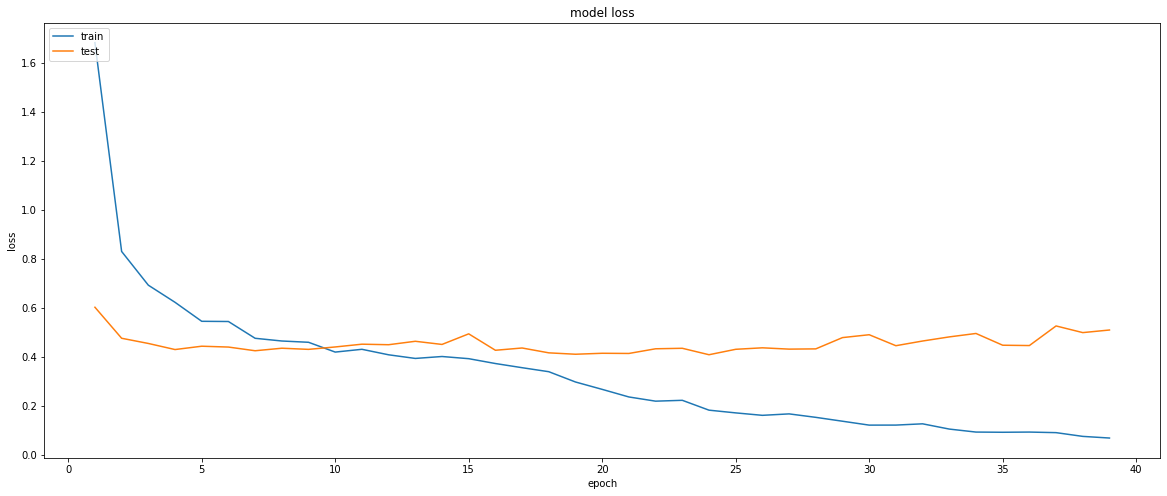

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

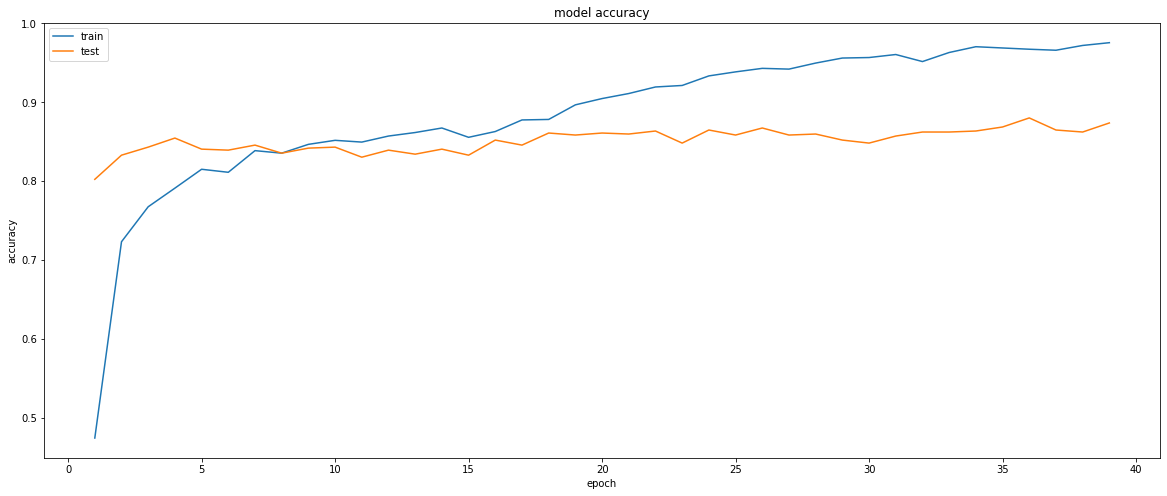

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Copiando para o Drive

In [ ]:
!zip -r {zip_name} {nome_modelo}

  adding: resnet50/ (stored 0%)
  adding: resnet50/assets/ (stored 0%)
  adding: resnet50/keras_metadata.pb (deflated 96%)
  adding: resnet50/variables/ (stored 0%)
  adding: resnet50/variables/variables.index (deflated 80%)
  adding: resnet50/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: resnet50/saved_model.pb (deflated 91%)


In [ ]:
shutil.copyfile(zip_name, drive_path_modelo)

PosixPath('/content/drive/MyDrive/CI1394/modelos/resnet50.zip')